In [14]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
# Load the dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display basic information
print(data.info())
print(data.describe())
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Check unique values in each column
for col in data.columns:
    print(f"{col}: {data[col].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [16]:
# Drop irrelevant columns
data.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Handle missing values in TotalCharges
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Replace 'No internet service' with 'No' for relevant columns
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    data[col] = data[col].replace({'No internet service': 'No'})

In [17]:
# Create tenure bins
data['tenure_bins'] = pd.cut(data['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '12-24', '24-48', '48-72'])

# Convert tenure_bins to one-hot encoding
tenure_bins_dummies = pd.get_dummies(data['tenure_bins'], prefix='tenure_bins', drop_first=True)
data = pd.concat([data.drop('tenure_bins', axis=1), tenure_bins_dummies], axis=1)

# Encode target variable (Churn)
data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})

# One-hot encode remaining categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Normalize numerical features
scaler = MinMaxScaler()
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

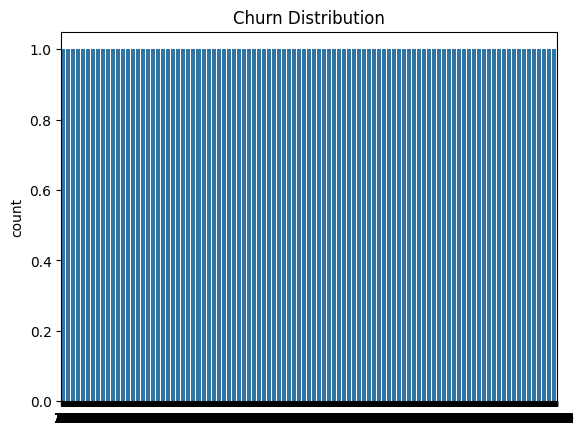

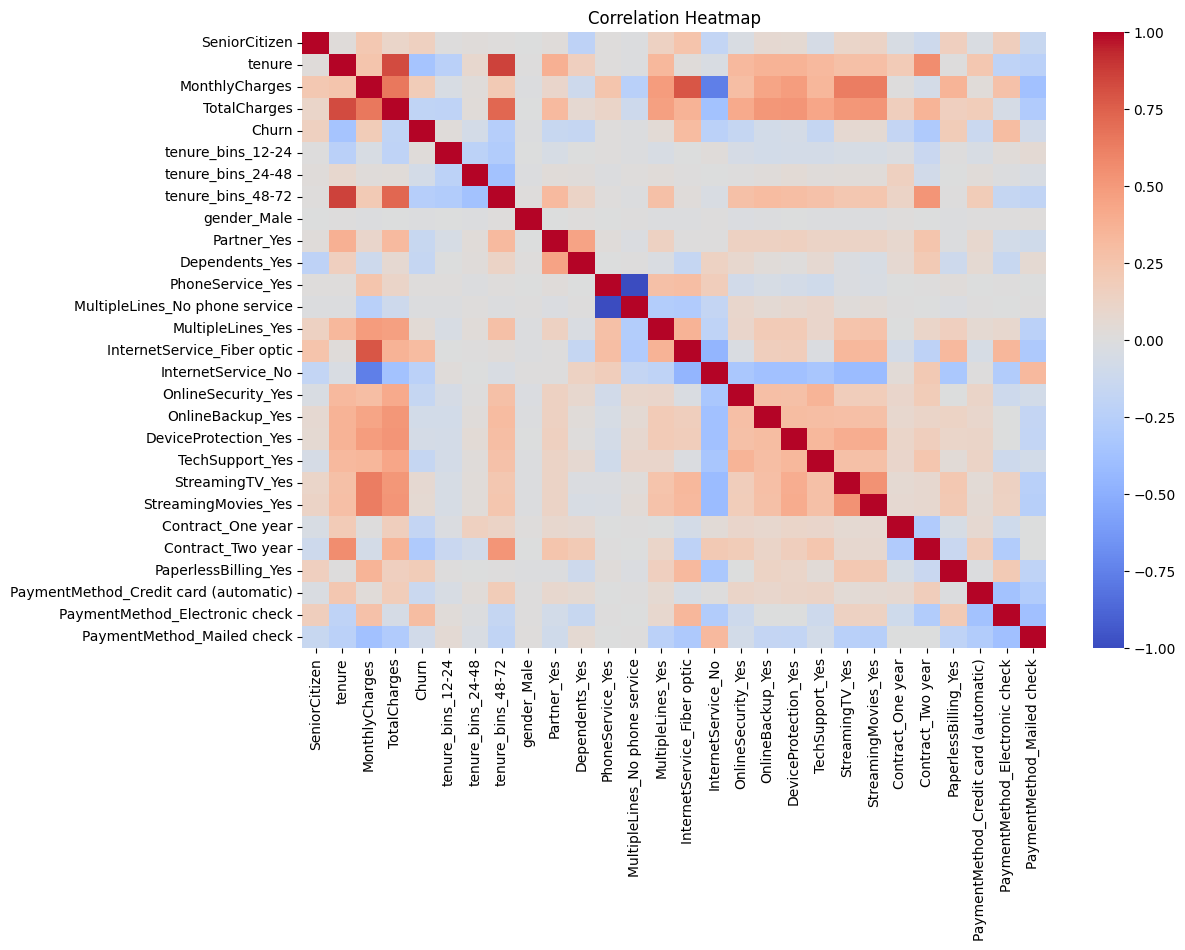

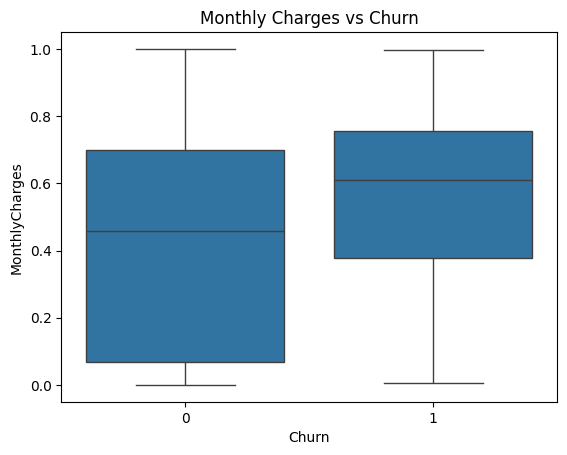

In [18]:
# Churn distribution
sns.countplot(data['Churn'])
plt.title("Churn Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Boxplot of MonthlyCharges by Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title("Monthly Charges vs Churn")
plt.show()

In [19]:
# Split dataset into features and target
X = data.drop("Churn", axis=1)
y = data["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ensure all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [20]:
# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7970191625266146
[[934 101]
 [185 189]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



Random Forest Accuracy: 0.7920511000709723
[[929 106]
 [187 187]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



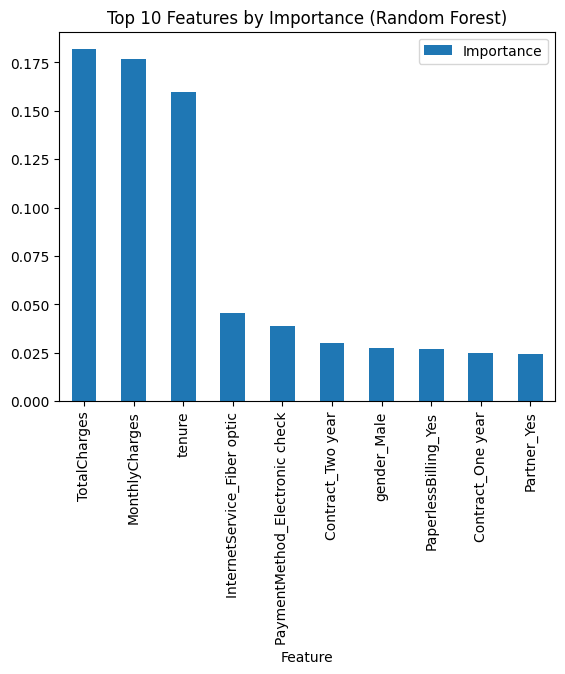

In [21]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False).head(10).plot.bar(x='Feature', y='Importance')
plt.title("Top 10 Features by Importance (Random Forest)")
plt.show()

In [22]:
# Train XGBoost
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7721788502484032
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



In [23]:
# Deep Learning Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate on test set
y_pred_dl = model.predict(X_test)
y_pred_dl = (y_pred_dl > 0.5).astype(int)
print("Deep Learning Accuracy:", accuracy_score(y_test, y_pred_dl))

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7409 - loss: 0.5421 - val_accuracy: 0.7906 - val_loss: 0.4439
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7895 - loss: 0.4512 - val_accuracy: 0.7906 - val_loss: 0.4371
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7947 - loss: 0.4304 - val_accuracy: 0.7933 - val_loss: 0.4349
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7935 - loss: 0.4304 - val_accuracy: 0.7879 - val_loss: 0.4386
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8007 - loss: 0.4253 - val_accuracy: 0.7906 - val_loss: 0.4344
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8034 - loss: 0.4219 - val_accuracy: 0.7950 - val_loss: 0.4341
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8090 - loss: 0.4178 - val_accuracy: 0.7977 - val_loss: 0.4344
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.4151 - val_accuracy: 0.

In [24]:
# Random Forest Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best Score:", grid_rf.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.7981870792953834


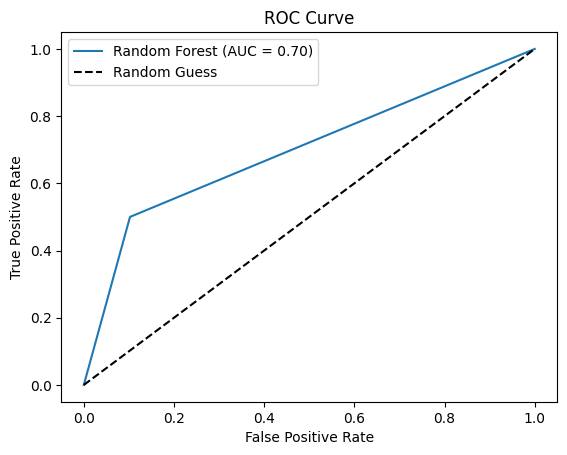

In [25]:
# ROC Curve for Random Forest
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_rf)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()